# Volcanic Rock Voucher - Volatility Strategy Research
This notebook computes mid-prices, premiums, implied volatility, and helps tune trading parameters for vouchers.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import NormalDist

price_files = [
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_0.csv",
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_1.csv",
    "/users/eleves-b/2023/youssef.nakhla/imc/2025/prices_round_3_day_2.csv"
]

# Map day index to timestamp offset
day_offsets = {
    0: 0,
    1: 1_000_000,
    2: 2_000_000
}

dfs = []

for i, file in enumerate(price_files):
    df = pd.read_csv(file)
    df = df.iloc[:, 0].str.split(";", expand=True)
    df.columns = [
        "day", "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ]
    
    # Convert numeric columns
    numeric_cols = df.columns.difference(["day", "timestamp", "product"])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Convert and shift timestamp
    df["timestamp"] = df["timestamp"].astype(int) + day_offsets[i]
    
    dfs.append(df)

# Concatenate all days into one dataframe
df = pd.concat(dfs, ignore_index=True)

In [18]:
class BlackScholes:
    @staticmethod
    def call_price(S, K, T, vol):
        d1 = (math.log(S / K) + 0.5 * vol ** 2 * T) / (vol * math.sqrt(T))
        d2 = d1 - vol * math.sqrt(T)
        return S * NormalDist().cdf(d1) - K * NormalDist().cdf(d2)

    @staticmethod
    def implied_vol(market_price, S, K, T, tol=1e-5, max_iter=100):
        low, high = 0.01, 2.0
        for _ in range(max_iter):
            mid = (low + high) / 2
            price = BlackScholes.call_price(S, K, T, mid)
            if abs(price - market_price) < tol:
                return mid
            if price > market_price:
                high = mid
            else:
                low = mid
        return mid

    @staticmethod
    def delta(S, K, T, vol):
        d1 = (math.log(S / K) + 0.5 * vol ** 2 * T) / (vol * math.sqrt(T))
        return NormalDist().cdf(d1)


In [27]:
# Extract IV per voucher
vouchers = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}
rock_df = df[df["product"] == "VOLCANIC_ROCK"]
results = []
print(df.head(20))
num_unique_timestamps = df["timestamp"].nunique()
print("Number of unique timestamps:", num_unique_timestamps)
for voucher, strike in vouchers.items():
    v_df = df[df["product"] == voucher]
    for t in sorted(df["timestamp"].unique()):
        r_row = rock_df[rock_df["timestamp"] == t]
        v_row = v_df[v_df["timestamp"] == t]
        if v_row.empty or r_row.empty:
            continue
        spot = r_row["mid_price"].values[0]
        bid = v_row["bid_price_1"].values[0]
        ask = v_row["ask_price_1"].values[0]
        premium = (bid + ask) / 2
        T = (7 - t // 1000000) / 7
        try:
            iv = BlackScholes.implied_vol(premium, spot, strike, T)
            delta = BlackScholes.delta(spot, strike, T, iv)
            results.append({
                "timestamp": t,
                "voucher": voucher,
                "strike": strike,
                "premium": premium,
                "spot": spot,
                "iv": iv,
                "delta": delta,
                "T": T
            })
        except:
            continue

iv_df = pd.DataFrame(results)
iv_df.head(20)


   day  timestamp                      product  bid_price_1  bid_volume_1  \
0    0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0   
1    0          0                      DJEMBES      13493.0          72.0   
2    0          0                   CROISSANTS       4321.0         111.0   
3    0          0                         JAMS       6631.0         210.0   
4    0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0          19.0   
5    0          0                         KELP       2028.0          30.0   
6    0          0   VOLCANIC_ROCK_VOUCHER_9750        754.0          19.0   
7    0          0               PICNIC_BASKET1      59223.0          19.0   
8    0          0               PICNIC_BASKET2      30502.0          43.0   
9    0          0   VOLCANIC_ROCK_VOUCHER_9500       1003.0          19.0   
10   0          0             RAINFOREST_RESIN       9992.0          30.0   
11   0          0  VOLCANIC_ROCK_VOUCHER_10250        273.0          19.0   

,timestamp,voucher,strike,premium,spot,iv,delta,T
0,0,VOLCANIC_ROCK_VOUCHER_9500,9500,1003.5,10503.0,0.038108,0.996010,1.0
1,100,VOLCANIC_ROCK_VOUCHER_9500,9500,1010.5,10510.0,0.038332,0.996034,1.0
2,200,VOLCANIC_ROCK_VOUCHER_9500,9500,1013.5,10513.0,0.038429,0.996044,1.0
3,300,VOLCANIC_ROCK_VOUCHER_9500,9500,1018.0,10517.5,0.038573,0.996059,1.0
4,400,VOLCANIC_ROCK_VOUCHER_9500,9500,1010.0,10509.5,0.038316,0.996032,1.0
5,500,VOLCANIC_ROCK_VOUCHER_9500,9500,1006.5,10506.0,0.038204,0.996020,1.0
6,600,VOLCANIC_ROCK_VOUCHER_9500,9500,1004.5,10503.5,0.041201,0.993011,1.0
7,700,VOLCANIC_ROCK_VOUCHER_9500,9500,1003.5,10503.0,0.038108,0.996010,1.0
8,800,VOLCANIC_ROCK_VOUCHER_9500,9500,997.5,10497.5,0.017773,1.000000,1.0
9,900,VOLCANIC_ROCK_VOUCHER_9500,9500,995.5,10495.5,0.017773,1.000000,1.0


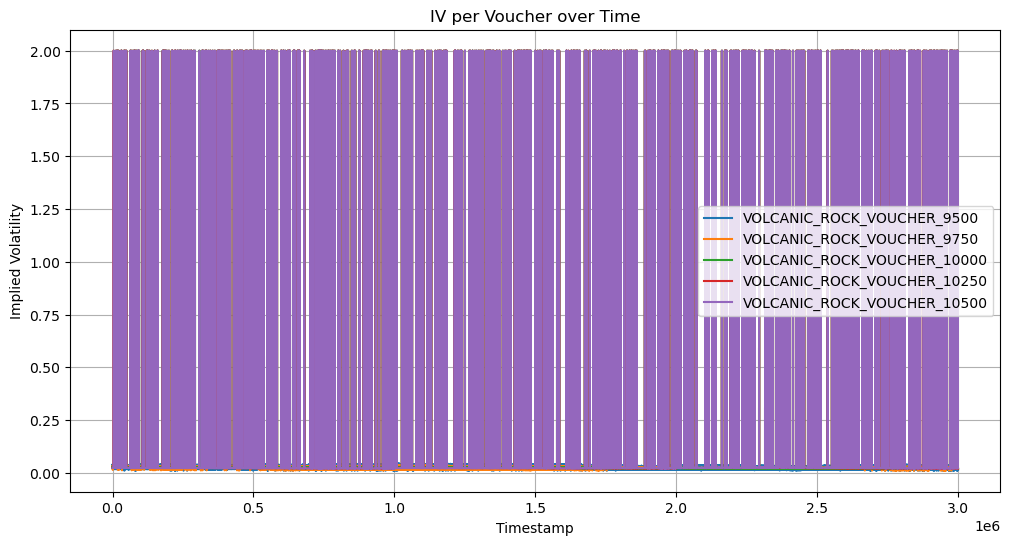

In [28]:
plt.figure(figsize=(12, 6))
for voucher in vouchers:
    plt.plot(iv_df[iv_df.voucher == voucher].timestamp, iv_df[iv_df.voucher == voucher].iv, label=voucher)
plt.xlabel("Timestamp")
plt.ylabel("Implied Volatility")
plt.title("IV per Voucher over Time")
plt.legend()
plt.grid(True)
plt.show()

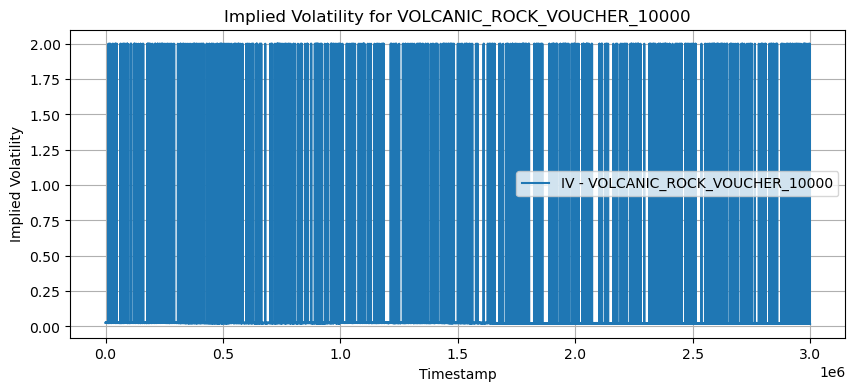

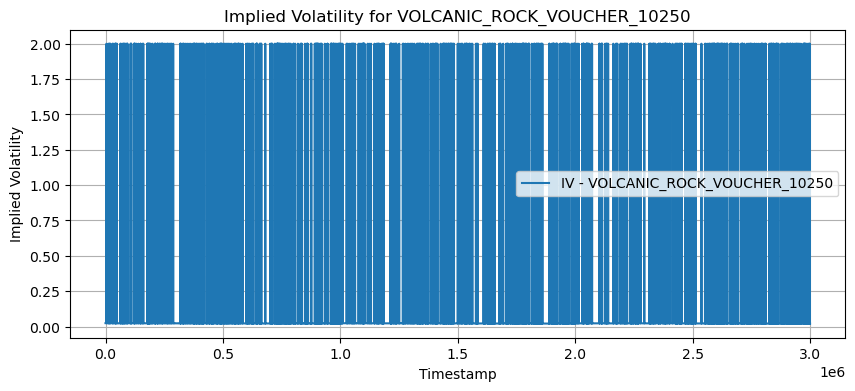

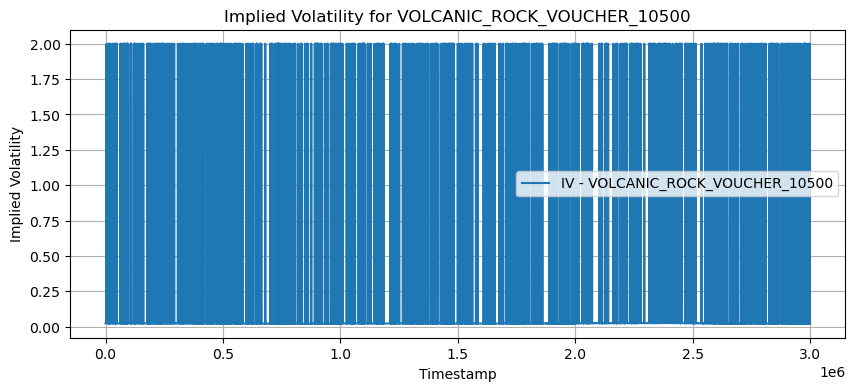

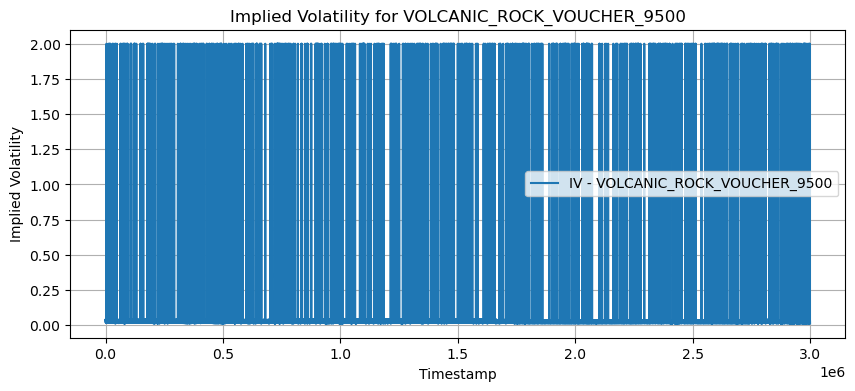

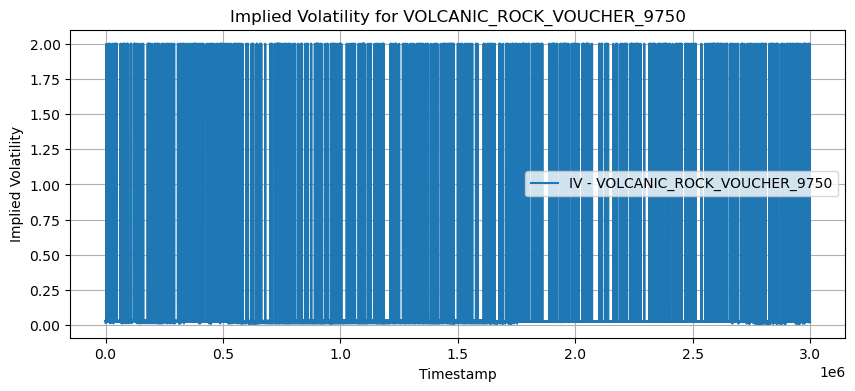

In [29]:
voucher_groups = iv_df.groupby("voucher")

for voucher, group in voucher_groups:
    plt.figure(figsize=(10, 4))
    plt.plot(group["timestamp"], group["iv"], label=f"IV - {voucher}")
    plt.title(f"Implied Volatility for {voucher}")
    plt.xlabel("Timestamp")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.show()

In [30]:
iv_df.groupby("voucher")[["iv"]].agg(["mean", "std"])

iv          
                                 mean       std
voucher                                        
VOLCANIC_ROCK_VOUCHER_10000  0.066945  0.289260
VOLCANIC_ROCK_VOUCHER_10250  0.066125  0.291623
VOLCANIC_ROCK_VOUCHER_10500  0.066895  0.292624
VOLCANIC_ROCK_VOUCHER_9500   0.068486  0.282360
VOLCANIC_ROCK_VOUCHER_9750   0.068479  0.285211

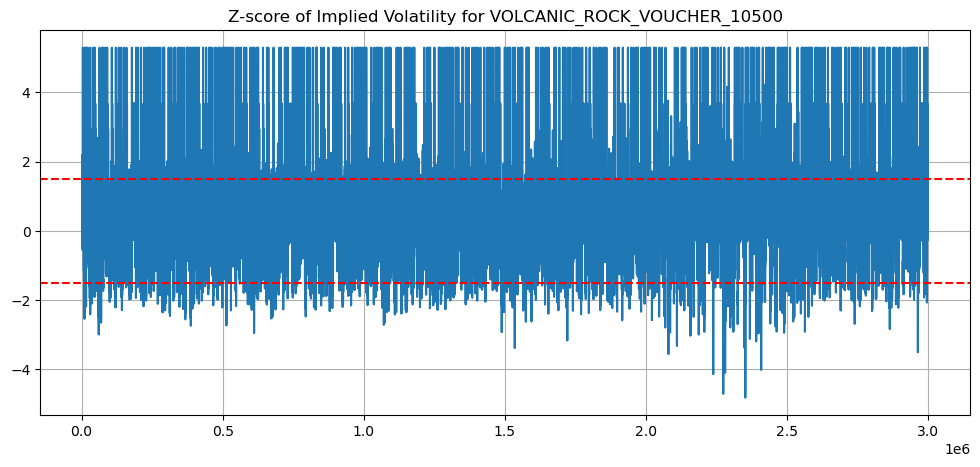

In [31]:
voucher = "VOLCANIC_ROCK_VOUCHER_10500"
window = 30
subset = iv_df[iv_df.voucher == voucher].copy()
subset["rolling_mean"] = subset["iv"].rolling(window).mean()
subset["rolling_std"] = subset["iv"].rolling(window).std()
subset["zscore"] = (subset["iv"] - subset["rolling_mean"]) / subset["rolling_std"]

plt.figure(figsize=(12,5))
plt.plot(subset["timestamp"], subset["zscore"])
plt.axhline(1.5, color="red", linestyle="--")
plt.axhline(-1.5, color="red", linestyle="--")
plt.title(f"Z-score of Implied Volatility for {voucher}")
plt.grid(True)
plt.show()

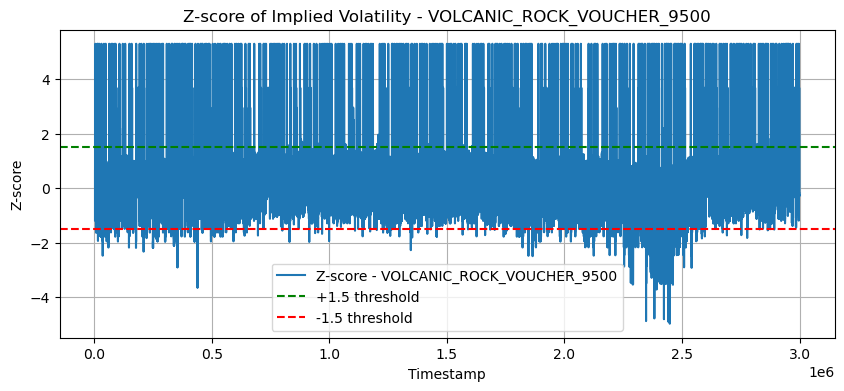

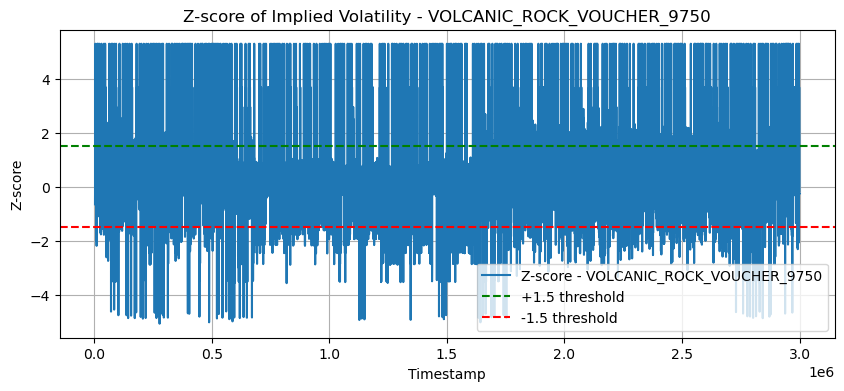

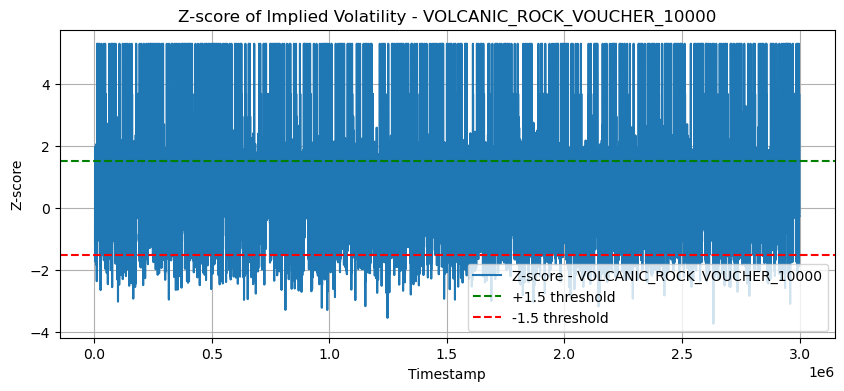

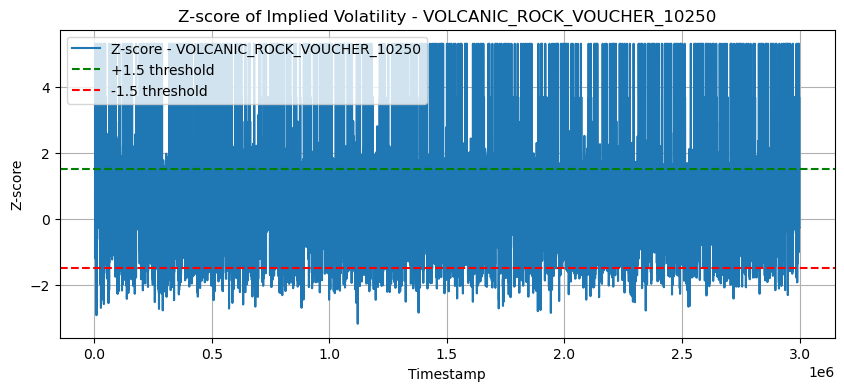

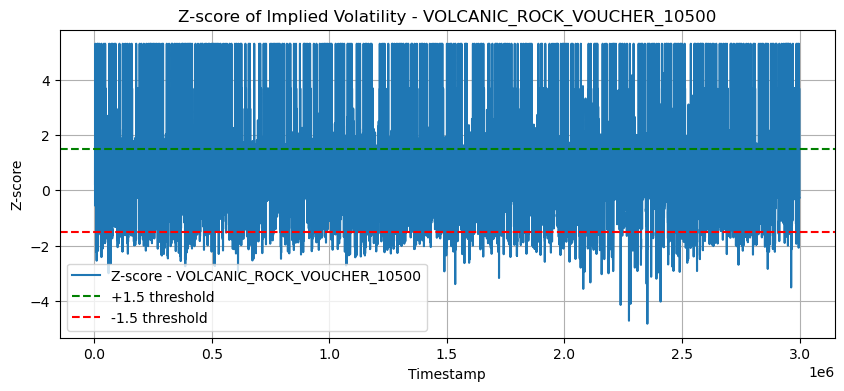

In [32]:
# Compute and plot z-scores for each voucher
rolling_window = 30

for voucher in iv_df["voucher"].unique():
    sub = iv_df[iv_df["voucher"] == voucher].copy()
    sub["rolling_mean"] = sub["iv"].rolling(rolling_window).mean()
    sub["rolling_std"] = sub["iv"].rolling(rolling_window).std()
    sub["zscore"] = (sub["iv"] - sub["rolling_mean"]) / sub["rolling_std"]

    plt.figure(figsize=(10, 4))
    plt.plot(sub["timestamp"], sub["zscore"], label=f"Z-score - {voucher}")
    plt.axhline(1.5, color="green", linestyle="--", label="+1.5 threshold")
    plt.axhline(-1.5, color="red", linestyle="--", label="-1.5 threshold")
    plt.title(f"Z-score of Implied Volatility - {voucher}")
    plt.xlabel("Timestamp")
    plt.ylabel("Z-score")
    plt.grid(True)
    plt.legend()
    plt.show()

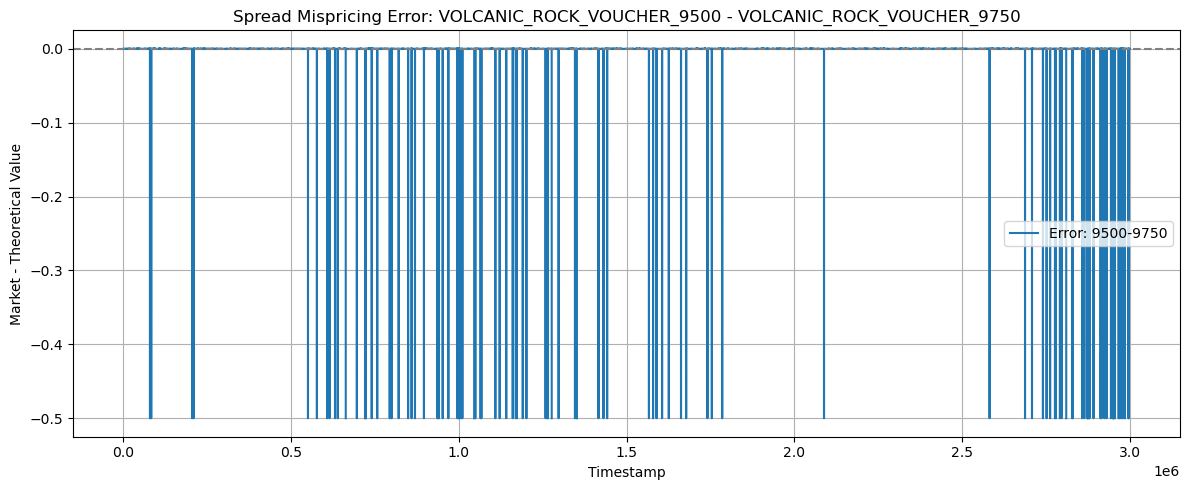

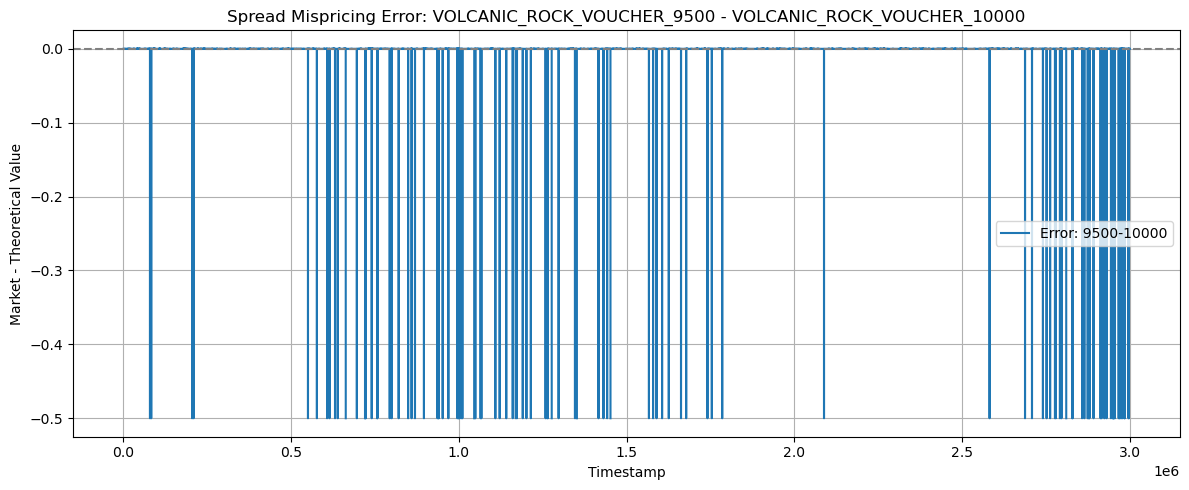

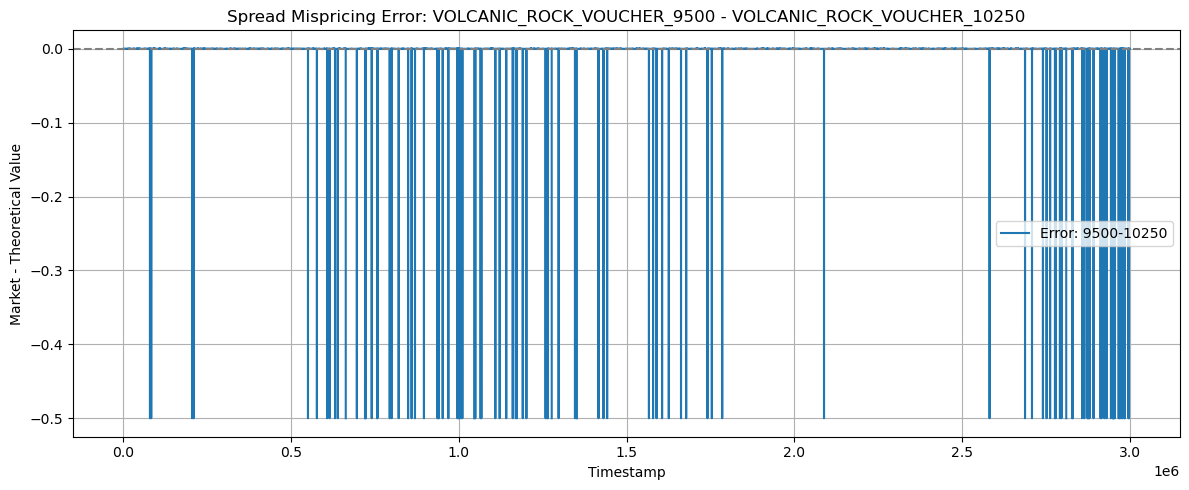

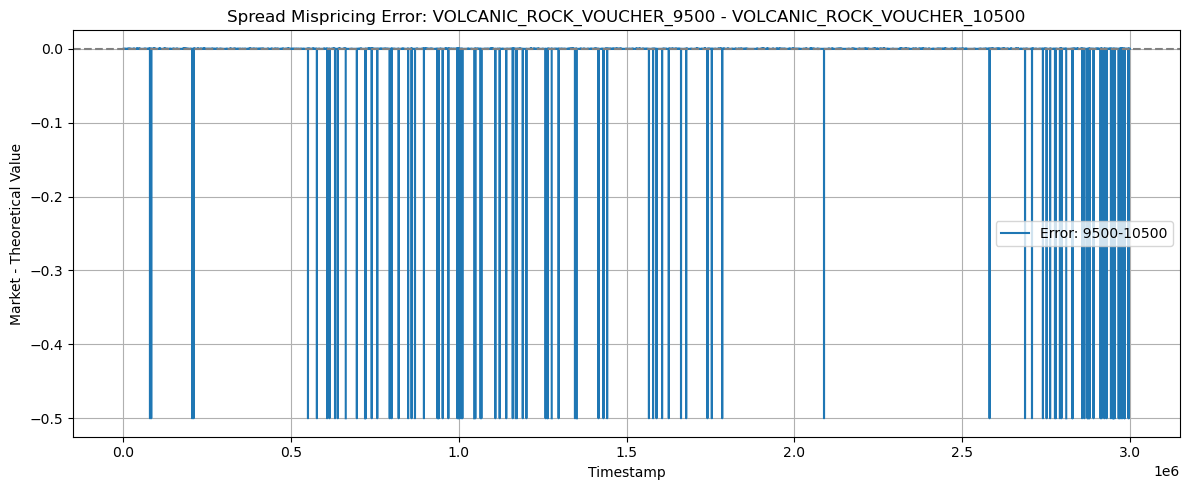

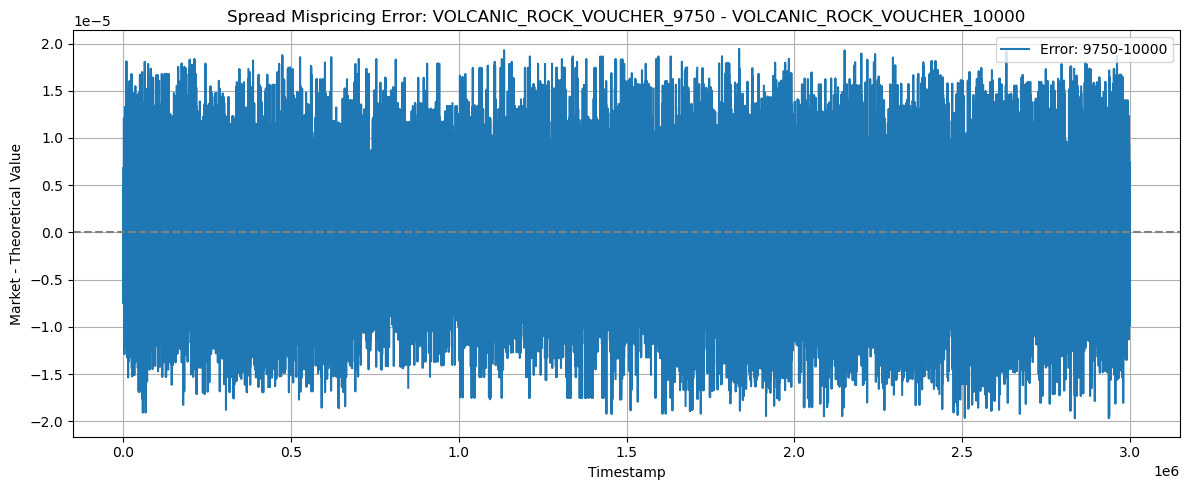

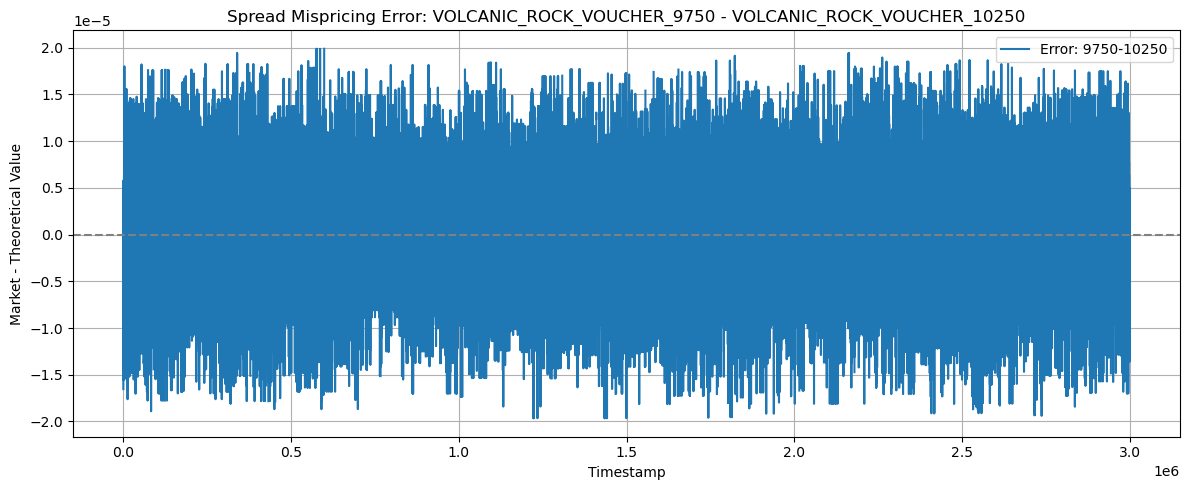

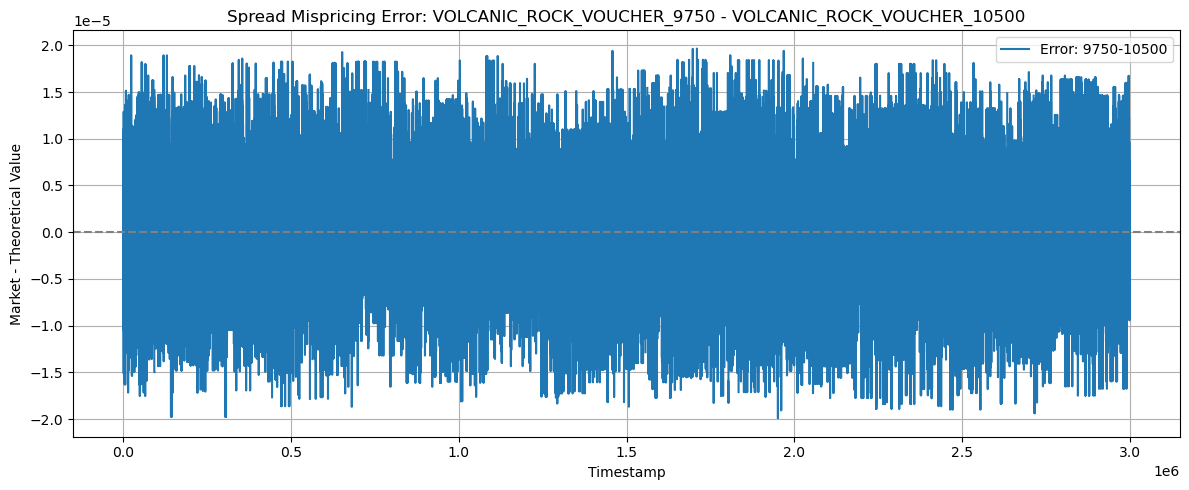

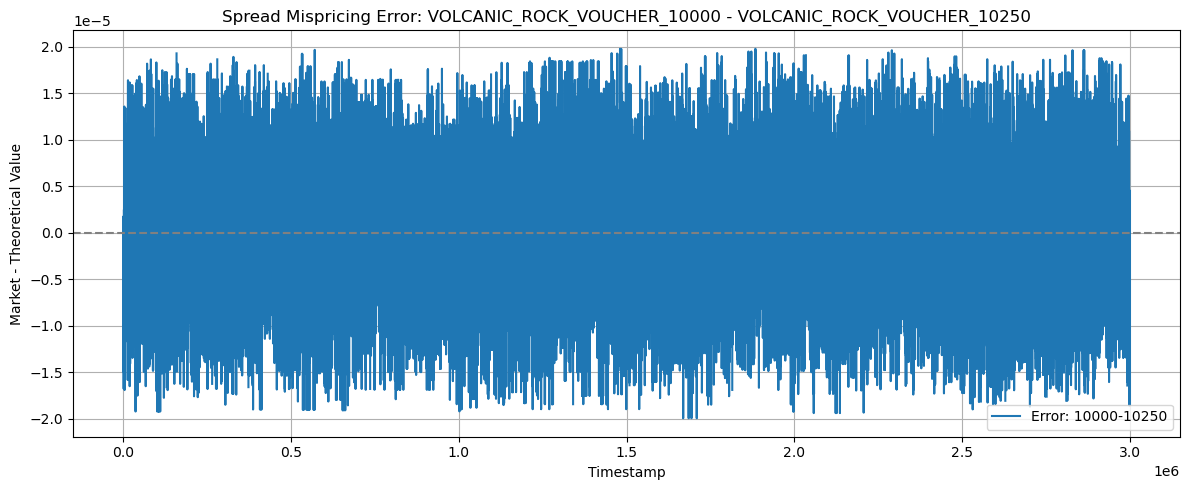

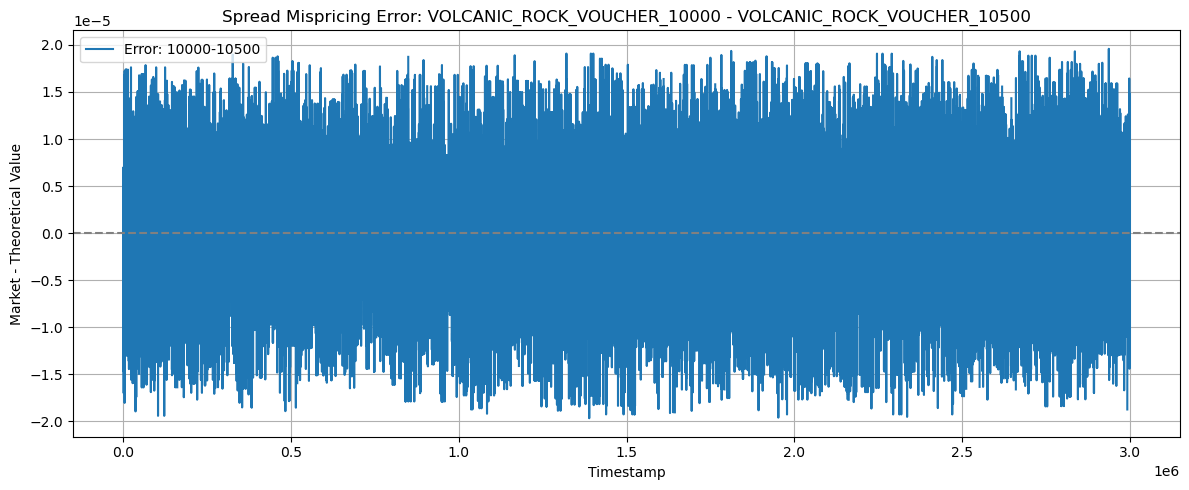

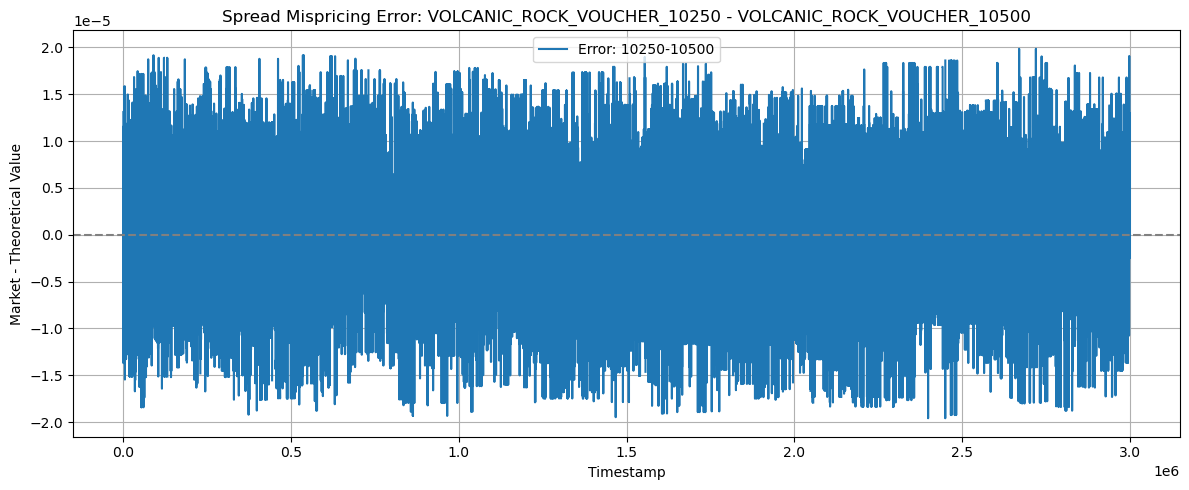

In [33]:
import itertools
import matplotlib.pyplot as plt

# --- 1. Define all vertical spread pairs (K1 < K2) ---
vouchers = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}

voucher_pairs = list(itertools.combinations(vouchers.items(), 2))  # All (K1, K2) pairs

# --- 2. Loop through each pair, compute market vs theoretical spread and plot ---
for (v1, K1), (v2, K2) in voucher_pairs:
    df1 = iv_df[iv_df.voucher == v1].copy()
    df2 = iv_df[iv_df.voucher == v2].copy()

    # Merge on timestamp
    merged = pd.merge(df1, df2, on="timestamp", suffixes=(f"_{K1}", f"_{K2}"))

    # Compute market spread
    merged["market_spread"] = merged[f"premium_{K1}"] - merged[f"premium_{K2}"]

    # Compute theoretical spread row-by-row
    def compute_theoretical_spread(row):
        c1 = BlackScholes.call_price(row[f"spot_{K1}"], K1, row[f"T_{K1}"], row[f"iv_{K1}"])
        c2 = BlackScholes.call_price(row[f"spot_{K1}"], K2, row[f"T_{K1}"], row[f"iv_{K2}"])
        return c1 - c2

    merged["theoretical_spread"] = merged.apply(compute_theoretical_spread, axis=1)

    # Compute mispricing error
    merged["error"] = merged["market_spread"] - merged["theoretical_spread"]

    # --- 3. Plot the spread mispricing ---
    plt.figure(figsize=(12, 5))
    plt.plot(merged["timestamp"], merged["error"], label=f"Error: {K1}-{K2}")

    plt.axhline(0, linestyle="--", color="gray")
    plt.title(f"Spread Mispricing Error: {v1} - {v2}")
    plt.xlabel("Timestamp")
    plt.ylabel("Market - Theoretical Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

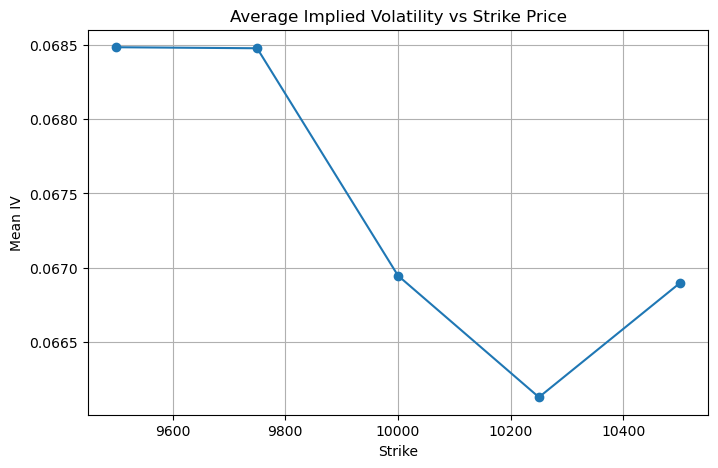

In [34]:
iv_means = iv_df.groupby("strike")["iv"].mean().sort_index()

plt.figure(figsize=(8, 5))
plt.plot(iv_means.index, iv_means.values, marker='o')
plt.title("Average Implied Volatility vs Strike Price")
plt.xlabel("Strike")
plt.ylabel("Mean IV")
plt.grid(True)
plt.show()